#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/competitions/precio-de-portatiles/overview

## Librerias

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import re

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Data

In [5]:
df = pd.read_csv("../data/data_mod/train.csv")


## Data exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB


In [7]:
df = df.drop(['id', 'laptop_ID'], axis=1)

In [8]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36kg,749.00
1,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Windows 10,2kg,449.00
2,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1460.00
3,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2868.99
4,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.26kg,1713.37


## Data processing

In [9]:
# Función para extraer GHz
def extract_ghz(cpu):
    match = re.search(r'(\d+\.\d+|\d+)GHz', cpu)
    return float(match.group(1)) if match else None

# Función para extraer la generación completa del procesador
def extract_generation(cpu):
    match = re.search(r'([A-Z]*\d{4}[A-Z]*|\dY\d{2})', cpu)
    if match:
        generation = match.group(0)
        if 'Y' in generation:  # Si la generación contiene 'Y'
            generation = generation.replace('Y', '1')  # Reemplazar 'Y' por '1'
        return generation
    else:
        return '7500'  # Devolvemos 7500 si no se encuentra un patrón reconocible

# Función para identificar el tipo de procesador
def extract_processor_type(cpu):
    match = re.search(r'^(Intel|AMD) (.+?) (\d|GHz)', cpu) 
    return match.group(1) + " " + match.group(2) if match else None

# Crear nuevas columnas
df['GHz'] = df['Cpu'].apply(extract_ghz)
df['Generation'] = df['Cpu'].apply(extract_generation)
df['Processor_Type'] = df['Cpu'].apply(extract_processor_type)


In [10]:
# Función para convertir la columna Ram a entero
def convert_ram(ram):
    return int(ram.replace('GB', ''))

# Aplicar la función a la columna Ram
df['Ram'] = df['Ram'].apply(convert_ram)

In [11]:
# Función para convertir la columna Weight a flotante
def convert_weight(weight):
    return float(weight.replace('kg', ''))

# Aplicar la función a la columna Weight
df['Weight'] = df['Weight'].apply(convert_weight)

In [12]:
# Función para agrupar tipos de memoria
def group_memory(memory):
    if 'HDD' in memory:
        return 'HDD'
    elif 'SSD' in memory:
        return 'SSD'
    elif 'Flash Storage' in memory:
        return 'Flash Storage'
    elif 'Hybrid' in memory:
        return 'Hybrid'
    else:
        return 'Other'

# Aplicar la función a la columna Memory
df['Memory_type'] = df['Memory'].apply(group_memory)

In [13]:
# Función para calcular el total de memoria en GB
def total_memory_gb(memory):
    # Expresión regular para encontrar valores numéricos
    pattern = r'(\d+(\.\d+)?)([TtGg]B)'

    # Encontrar todos los valores numéricos en la entrada de memoria
    matches = re.findall(pattern, memory)

    # Inicializar la suma total de memoria
    total_gb = 0

    # Convertir cada valor numérico a GB y sumarlos
    for match in matches:
        value = float(match[0])
        unit = match[2].lower()
        if unit == 'tb':
            total_gb += value * 1024  # Convertir TB a GB
        else:
            total_gb += value

    return total_gb

# Crear una nueva columna con el total de memoria en GB
df['Total_Memory_GB'] = df['Memory'].apply(total_memory_gb)

In [14]:
mean_prices_company = df.groupby('Company')['Price_euros'].mean().reset_index()
mean_prices_company_map = mean_prices_company.set_index('Company')['Price_euros'].to_dict()


In [15]:
mean_prices_TypeName = df.groupby('TypeName')['Price_euros'].mean().reset_index()
mean_prices_TypeName_map = mean_prices_TypeName.set_index('TypeName')['Price_euros'].to_dict()

In [16]:
mean_prices_ScreenResolution = df.groupby('ScreenResolution')['Price_euros'].mean().reset_index()
mean_prices_ScreenResolution_map = mean_prices_ScreenResolution.set_index('ScreenResolution')['Price_euros'].to_dict()

In [17]:
mean_prices_GHz = df.groupby('GHz')['Price_euros'].mean().reset_index()
mean_prices_GHz_map = mean_prices_GHz.set_index('GHz')['Price_euros'].to_dict()
mean_prices_Generation = df.groupby('Generation')['Price_euros'].mean().reset_index()
mean_prices_Generation_map = mean_prices_Generation.set_index('Generation')['Price_euros'].to_dict()
mean_prices_Processor_Type = df.groupby('Processor_Type')['Price_euros'].mean().reset_index()
mean_prices_Processor_Type_map = mean_prices_Processor_Type.set_index('Processor_Type')['Price_euros'].to_dict()

In [18]:
mean_prices_Memory_type = df.groupby('Memory_type')['Price_euros'].mean().reset_index()
mean_prices_Memory_type_map = mean_prices_Memory_type.set_index('Memory_type')['Price_euros'].to_dict()

In [19]:
mean_prices_OpSys = df.groupby('OpSys')['Price_euros'].mean().reset_index()
mean_prices_OpSys_map = mean_prices_OpSys.set_index('OpSys')['Price_euros'].to_dict()

In [20]:
mean_prices_Gpu = df.groupby('Gpu')['Price_euros'].mean().reset_index()
mean_prices_Gpu_map = mean_prices_Gpu.set_index('Gpu')['Price_euros'].to_dict()

In [21]:
df['Mean_Price_company'] = df['Company'].map(mean_prices_company_map)
df['Mean_Price_TypeName'] = df['TypeName'].map(mean_prices_TypeName_map)
df['Mean_Price_ScreenResolution'] = df['ScreenResolution'].map(mean_prices_ScreenResolution_map)
df['Mean_Price_GHz'] = df['GHz'].map(mean_prices_GHz_map)
df['Mean_Price_Generation'] = df['Generation'].map(mean_prices_Generation_map)
df['Mean_Price_Processor_Type'] = df['Processor_Type'].map(mean_prices_Processor_Type_map)
df['Mean_Price_Memory_type'] = df['Memory_type'].map(mean_prices_Memory_type_map)
df['Mean_Price_OpSys'] = df['OpSys'].map(mean_prices_OpSys_map)
df['Mean_Price_Gpu'] = df['Gpu'].map(mean_prices_Gpu_map)

<Axes: >

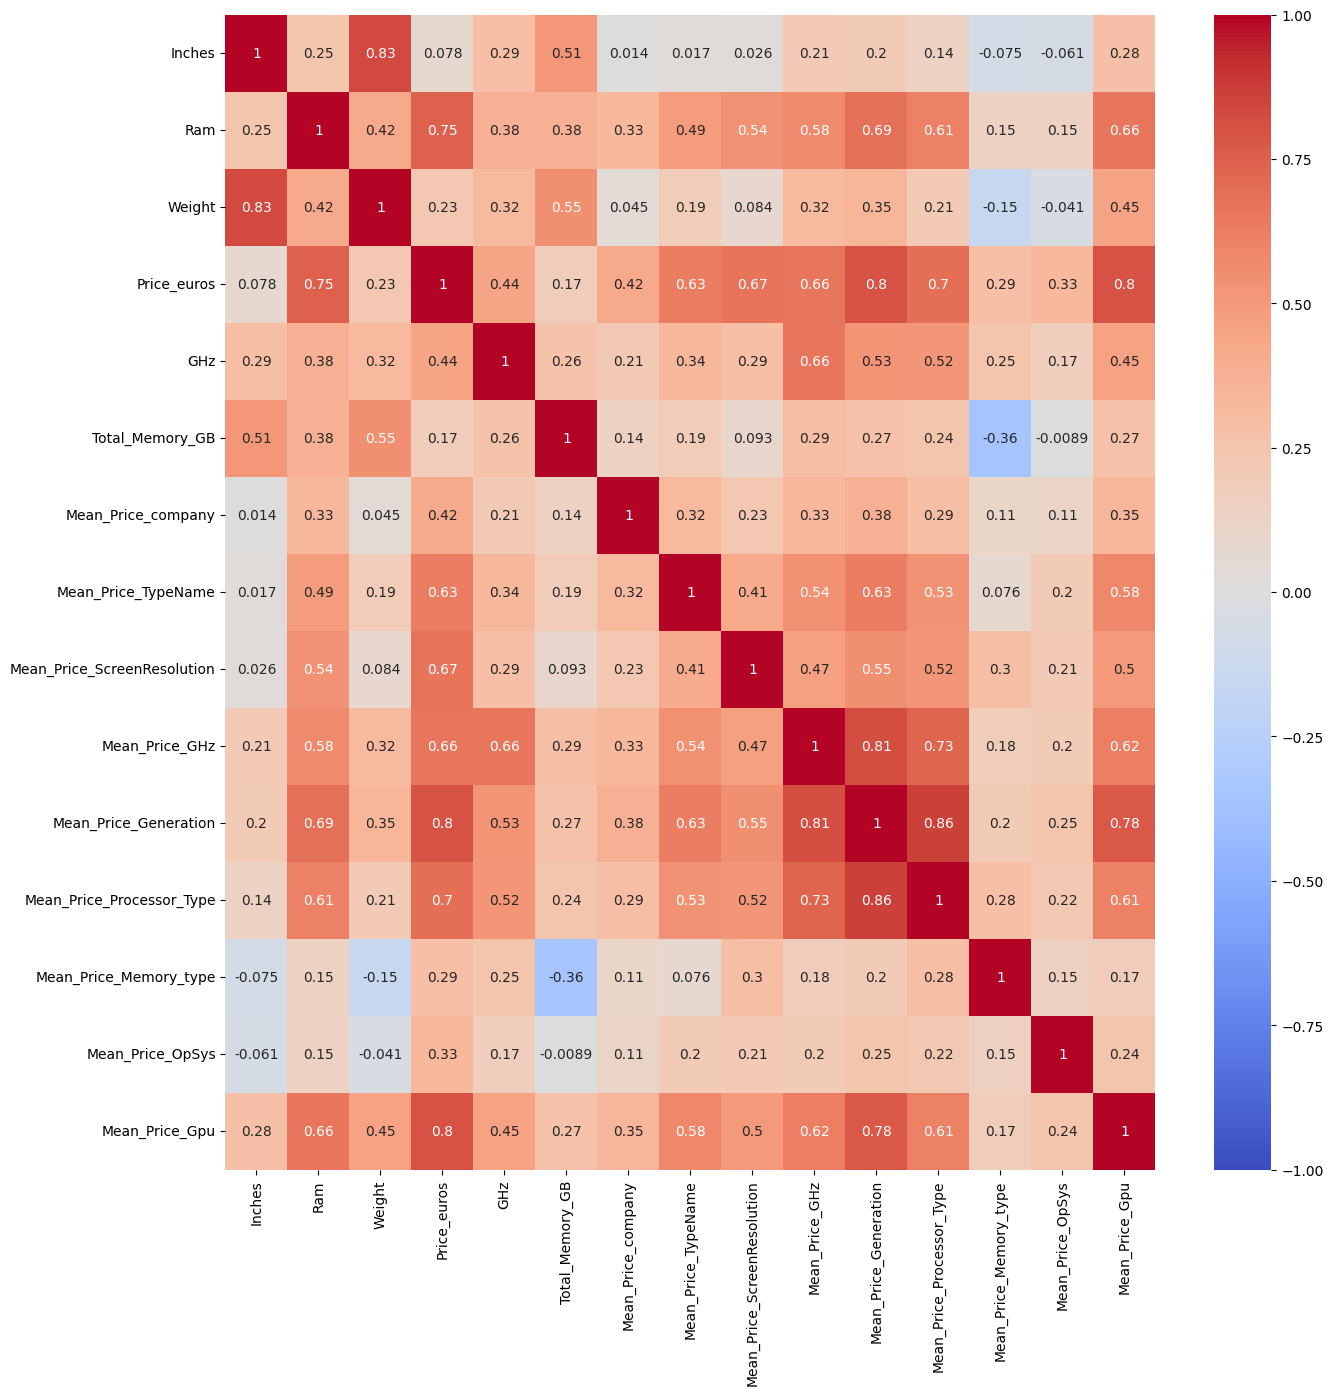

In [22]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(numeric_only=True),annot=True,vmin=-1,cmap='coolwarm')

In [23]:
# Seleccionar solo las columnas numéricas
df_num = df.select_dtypes(include=['int', 'float'])

In [24]:
df_num

,Inches,Ram,Weight,Price_euros,GHz,Total_Memory_GB,Mean_Price_company,Mean_Price_TypeName,Mean_Price_ScreenResolution,Mean_Price_GHz,Mean_Price_Generation,Mean_Price_Processor_Type,Mean_Price_Memory_type,Mean_Price_OpSys,Mean_Price_Gpu
0,15.6,8,2.36,749.00,2.7,1024.0,1175.476570,768.970575,536.252163,1393.627383,1312.296556,1600.475214,980.912356,1150.116461,885.563333
1,15.6,4,2.00,449.00,1.1,1024.0,1034.531852,768.970575,536.252163,413.440000,448.363846,437.235833,980.912356,1150.116461,459.490000
2,13.3,8,1.20,1460.00,2.3,256.0,1236.594595,768.970575,1130.398382,1022.054615,1014.556078,1008.343934,1290.014967,1765.166875,1007.587536
3,15.6,16,4.42,2868.99,2.8,1280.0,1175.476570,1764.080217,2857.436000,1785.973070,1781.305000,1600.475214,980.912356,1150.116461,2647.110833
4,12.5,8,1.26,1713.37,2.4,256.0,1175.476570,1530.688148,1402.203438,830.104500,1430.898889,1008.343934,1290.014967,1765.166875,1007.587536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,11.6,4,1.25,389.00,1.6,32.0,644.774800,1248.470471,389.000000,661.680306,292.561905,292.561905,548.684340,565.545000,316.245357
908,13.3,4,1.20,1195.00,2.3,128.0,1236.594595,768.970575,1130.398382,1022.054615,1014.556078,1008.343934,1290.014967,1150.116461,1007.587536
909,15.6,8,2.40,449.00,2.2,1024.0,644.774800,768.970575,536.252163,857.371250,418.000000,418.000000,980.912356,1150.116461,425.748750
910,14.0,8,1.36,1775.00,2.8,256.0,1175.476570,1530.688148,1130.398382,1785.973070,1911.094444,1600.475214,1290.014967,1150.116461,1110.493719


In [25]:
def select_high_correlation_columns(df, target_column, umbral):
    """
    Calcula la correlación entre las columnas del DataFrame y selecciona
    solo aquellas que tienen una correlación superior al umbral dado con la columna objetivo.

    Parámetros:
        - df (DataFrame): El DataFrame de entrada.
        - target_column (str): El nombre de la columna objetivo.
        - threshold (float): El umbral de correlación.

    Retorna:
        - DataFrame: Un nuevo DataFrame con las columnas que superan el umbral de correlación.
    """
    # Calcular la correlación con la columna objetivo
    correlations = df.corr()[target_column].abs()

    # Seleccionar las columnas que superan el umbral de correlación
    high_correlation_columns = correlations[correlations > umbral].index.tolist()

    # Crear un nuevo DataFrame con las columnas seleccionadas
    selected_df = df[high_correlation_columns]

    return selected_df


In [26]:
df_umbral_corr = select_high_correlation_columns(df_num, 'Price_euros', 0.5)

<Axes: >

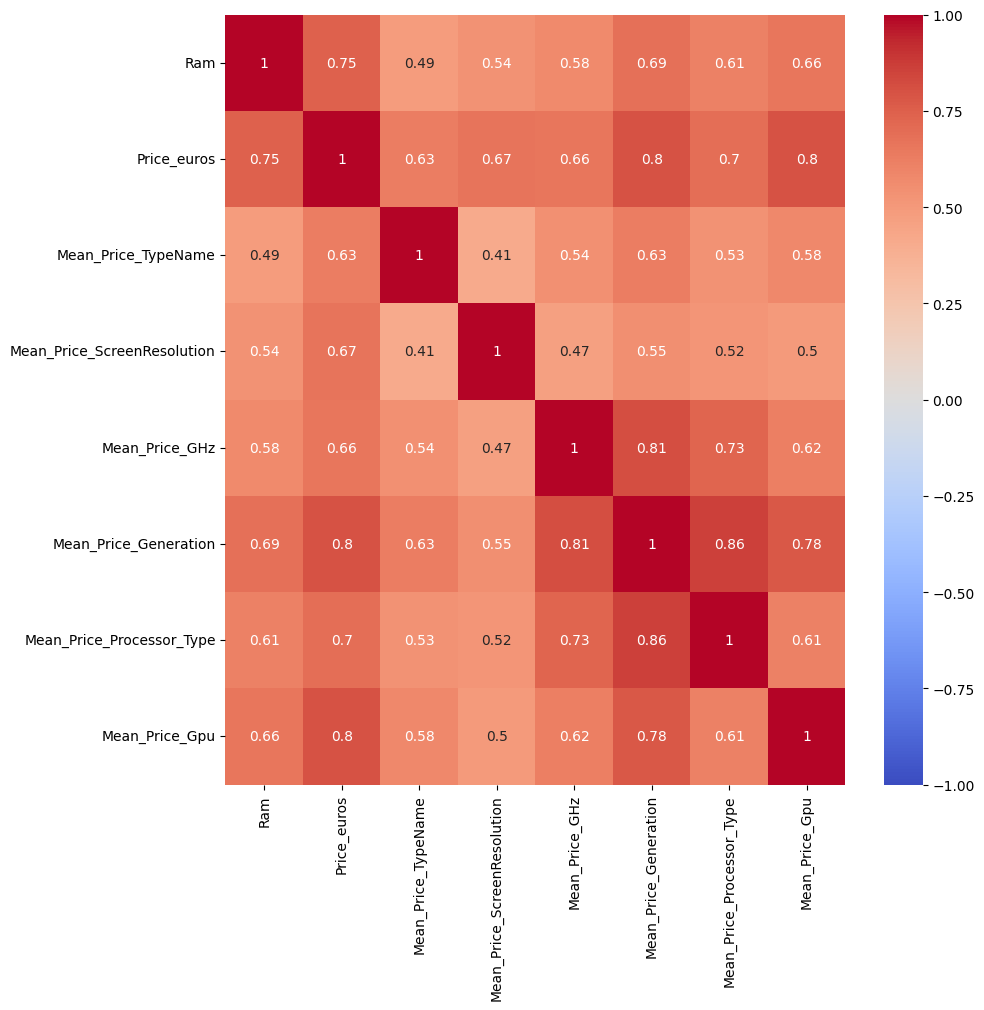

In [27]:
plt.figure(figsize=(10,10))
sns.heatmap(df_umbral_corr.corr(),annot=True,vmin=-1,cmap='coolwarm')

-----------------------------------------------------------------------------------------------------------------

## Pasos que si o si debéis realizar para poder participar en la competición:

### 1. Definir X e y

In [28]:
X = df_num.drop(columns=['Price_euros'])
y = df_num['Price_euros']

### 2. Dividir X_train, X_test, y_train, y_test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 35)

### 3. Crear y entrenar el modelo


In [30]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("reduce_dim", 'passthrough'),
    ("regresor", GradientBoostingRegressor())
])

# Definir el espacio de búsqueda de hiperparámetros solo para GradientBoostingRegressor
param_grid = [
    {
        'scaler': [None, StandardScaler()],
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': [10, 11, 12, 13, 14],
        'regresor__n_estimators': [50, 100, 150],
        'regresor__max_depth': [3, 5]
    },
    {
        'scaler': [None, StandardScaler()],
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': [10, 11, 12, 13, 14],
        'regresor__n_estimators': [50, 100, 150],
        'regresor__max_depth': [3, 5]
    }
]

# Param grid comentado para otros regresores (puedes descomentar para futuras pruebas)
'''
param_grid = [
    {
        #'scaler': [None, StandardScaler()],
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': [10, 11, 12, 13, 14, 15],
        'regresor': [DecisionTreeRegressor()],
        'regresor__max_depth': [3, 4, 5],
        'regresor__criterion': ['mse', 'mae']
    },
    {
        #'scaler': [None, StandardScaler()],
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': [10, 11, 12, 13, 14, 15],
        'regresor': [KNeighborsRegressor()],
        'regresor__n_neighbors': [5, 10, 15]
    },
    {
        #'scaler': [None, StandardScaler()],
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': [10, 11, 12, 13, 14, 15],
        'regresor': [SVR()],
        'regresor__C': [0.001, 0.1, 1, 10],
        'regresor__kernel': ['linear', 'rbf']
    },
    {
        #'scaler': [None, StandardScaler()],
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': [10, 11, 12, 13, 14, 15],
        'regresor': [RandomForestRegressor()],
        'regresor__n_estimators': [50, 100, 150],
        'regresor__max_depth': [3, 5, None]
    },
    {
        'scaler': [None, StandardScaler()],
        'reduce_dim': [SelectKBest(), PCA()],
        'reduce_dim__k': [10, 11, 12, 13, 14, 15],
        'regresor': [GradientBoostingRegressor()],
        'regresor__n_estimators': [50, 100, 150],
        'regresor__max_depth': [3, 5]
    }
]
'''

# Realizar la búsqueda de hiperparámetros solo para GradientBoostingRegressor
mejor_regresor = GridSearchCV(estimator=pipe,
                               param_grid=param_grid,
                               cv=5,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1)

# Entrenar el modelo
mejor_regresor.fit(X_train, y_train)

# Obtener el mejor modelo
modelo = mejor_regresor.best_estimator_


### 4. Sacar métricas, valorar el modelo 

Recuerda que en la competición se va a evaluar con la métrica de MAE.

In [31]:
# Predecir sobre el conjunto de prueba
y_pred = modelo.predict(X_test)

# Calcular el MAE sobre el conjunto de prueba
mae = mean_absolute_error(y_test, y_pred)

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Inches                       912 non-null    float64
 1   Ram                          912 non-null    int64  
 2   Weight                       912 non-null    float64
 3   GHz                          912 non-null    float64
 4   Total_Memory_GB              912 non-null    float64
 5   Mean_Price_company           912 non-null    float64
 6   Mean_Price_TypeName          912 non-null    float64
 7   Mean_Price_ScreenResolution  912 non-null    float64
 8   Mean_Price_GHz               912 non-null    float64
 9   Mean_Price_Generation        912 non-null    float64
 10  Mean_Price_Processor_Type    912 non-null    float64
 11  Mean_Price_Memory_type       912 non-null    float64
 12  Mean_Price_OpSys             912 non-null    float64
 13  Mean_Price_Gpu      

In [33]:
print("Mejores parámetros:", mejor_regresor.best_params_)
print("MAE:", mae)

Mejores parámetros: {'reduce_dim': SelectKBest(), 'reduce_dim__k': 14, 'regresor__max_depth': 5, 'regresor__n_estimators': 100, 'scaler': None}
MAE: 164.3841122814948


-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir con el dataset de predicción 

Definición de **modelo que está listo**. 

Tras hacer suficientes pruebas, analizar los datos, hacer feature engineering, probar diferentes modelos con diferentes parámetros, es con este con el que observo mejores métricas y menos overfitting. ¡Cuidado con el overfitting aquí! Si vuestro modelo aprende muy bien de estos datos pero hay overfitting cuando le pasemos los datos desconocidos de `test.csv` nos arriesgamos a que digamos, no salga lo esperado.

### 1. Entrena dicho modelo con TODOS tus datos de train, esto es con `train.csv` al completo.


**CON LAS TRANSFORMACIONES QUE LE HAYAS REALIZADO A `X` INCLUÍDAS.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

In [34]:
# Realizar la búsqueda de hiperparámetros
mejor_regresor_total = GridSearchCV(estimator=pipe,
                               param_grid=param_grid,
                               cv=5,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1)

# Entrenar el modelo
mejor_regresor_total.fit(X, y)

# Obtener el mejor modelo
modelo = mejor_regresor_total.best_estimator_

### 2. Carga los datos de `test.csv` para predecir.

In [35]:
df_test = pd.read_csv("../data/data_mod/test.csv")

**¿Por qué puede dar error?** 

IMPORTANTE: APLICAR A ESTOS DATOS LO MISMO QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 391 FILAS, SI O SI

**Entonces, si al cargar los datos de train usé `index_col=0` para que utilizara la primera columna del conjunto de datos como índice, ¿tendré que hacerlo también para el conjunto `test.csv`?**

In [36]:
df_test = df_test.drop(['id', 'laptop_ID'], axis=1)

# Función para extraer GHz
def extract_ghz(cpu):
    match = re.search(r'(\d+\.\d+|\d+)GHz', cpu)
    return float(match.group(1)) if match else None

# Función para extraer la generación completa del procesador
def extract_generation(cpu):
    match = re.search(r'([A-Z]*\d{4}[A-Z]*|\dY\d{2})', cpu)
    if match:
        generation = match.group(0)
        if 'Y' in generation:  # Si la generación contiene 'Y'
            generation = generation.replace('Y', '1')  # Reemplazar 'Y' por '1'
        return generation
    else:
        return '7500'  # Devolvemos None si no se encuentra un patrón reconocible

# Función para identificar el tipo de procesador
def extract_processor_type(cpu):
    match = re.search(r'^(Intel|AMD) (.+?) (\d|GHz)', cpu) 
    return match.group(1) + " " + match.group(2) if match else None

# Crear nuevas columnas
df_test['GHz'] = df_test['Cpu'].apply(extract_ghz)
df_test['Generation'] = df_test['Cpu'].apply(extract_generation)
df_test['Processor_Type'] = df_test['Cpu'].apply(extract_processor_type)




# Función para convertir la columna Ram a entero
def convert_ram(ram):
    return int(ram.replace('GB', ''))

# Aplicar la función a la columna Ram
df_test['Ram'] = df_test['Ram'].apply(convert_ram)




# Función para convertir la columna Weight a flotante
def convert_weight(weight):
    return float(weight.replace('kg', ''))

# Aplicar la función a la columna Weight
df_test['Weight'] = df_test['Weight'].apply(convert_weight)



# Función para agrupar tipos de memoria
def group_memory(memory):
    if 'HDD' in memory:
        return 'HDD'
    elif 'SSD' in memory:
        return 'SSD'
    elif 'Flash Storage' in memory:
        return 'Flash Storage'
    elif 'Hybrid' in memory:
        return 'Hybrid'
    else:
        return 'Other'

# Aplicar la función a la columna Memory
df_test['Memory_type'] = df_test['Memory'].apply(group_memory)



# Función para calcular el total de memoria en GB
def total_memory_gb(memory):
    # Expresión regular para encontrar valores numéricos
    pattern = r'(\d+(\.\d+)?)([TtGg]B)'

    # Encontrar todos los valores numéricos en la entrada de memoria
    matches = re.findall(pattern, memory)

    # Inicializar la suma total de memoria
    total_gb = 0

    # Convertir cada valor numérico a GB y sumarlos
    for match in matches:
        value = float(match[0])
        unit = match[2].lower()
        if unit == 'tb':
            total_gb += value * 1024  # Convertir TB a GB
        else:
            total_gb += value

    return total_gb

# Crear una nueva columna con el total de memoria en GB
df_test['Total_Memory_GB'] = df_test['Memory'].apply(total_memory_gb)



df_test['Mean_Price_company'] = df_test['Company'].map(mean_prices_company_map)
df_test['Mean_Price_TypeName'] = df_test['TypeName'].map(mean_prices_TypeName_map)
df_test['Mean_Price_ScreenResolution'] = df_test['ScreenResolution'].map(mean_prices_ScreenResolution_map)
df_test['Mean_Price_GHz'] = df_test['GHz'].map(mean_prices_GHz_map)
df_test['Mean_Price_Generation'] = df_test['Generation'].map(mean_prices_Generation_map)
df_test['Mean_Price_Processor_Type'] = df_test['Processor_Type'].map(mean_prices_Processor_Type_map)
df_test['Mean_Price_Memory_type'] = df_test['Memory_type'].map(mean_prices_Memory_type_map)
df_test['Mean_Price_OpSys'] = df_test['OpSys'].map(mean_prices_OpSys_map)
df_test['Mean_Price_Gpu'] = df_test['Gpu'].map(mean_prices_Gpu_map)


In [37]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Company                      391 non-null    object 
 1   Product                      391 non-null    object 
 2   TypeName                     391 non-null    object 
 3   Inches                       391 non-null    float64
 4   ScreenResolution             391 non-null    object 
 5   Cpu                          391 non-null    object 
 6   Ram                          391 non-null    int64  
 7   Memory                       391 non-null    object 
 8   Gpu                          391 non-null    object 
 9   OpSys                        391 non-null    object 
 10  Weight                       391 non-null    float64
 11  GHz                          391 non-null    float64
 12  Generation                   391 non-null    object 
 13  Processor_Type      

![](https://www.tierraljelechu.com/web/img/wiki_up/1.996-SorpresaDto.-1-Red.jpg)

In [38]:
# Rellenar NaNs solo en las columnas especificadas
df_test['Mean_Price_Gpu'] = df_test['Mean_Price_Gpu'].fillna(df_test['Mean_Price_Gpu'].mean())
df_test['Mean_Price_ScreenResolution'] = df_test['Mean_Price_ScreenResolution'].fillna(df_test['Mean_Price_ScreenResolution'].mean())
df_test['Mean_Price_Generation'] = df_test['Mean_Price_Generation'].fillna(df_test['Mean_Price_Generation'].mean())
df_test['Mean_Price_Processor_Type'] = df_test['Mean_Price_Processor_Type'].fillna(df_test['Mean_Price_Processor_Type'].mean())

In [39]:
# Seleccionar solo las columnas numéricas
df_num_test = df_test.select_dtypes(include=['int', 'float'])
df_num_test

,Inches,Ram,Weight,GHz,Total_Memory_GB,Mean_Price_company,Mean_Price_TypeName,Mean_Price_ScreenResolution,Mean_Price_GHz,Mean_Price_Generation,Mean_Price_Processor_Type,Mean_Price_Memory_type,Mean_Price_OpSys,Mean_Price_Gpu
0,13.3,16,1.30,2.7,512.0,1042.357884,1530.688148,2857.436000,1393.627383,1312.296556,1600.475214,1290.014967,1150.116461,1110.493719
1,15.6,8,2.20,2.7,256.0,644.774800,768.970575,536.252163,1393.627383,600.714000,605.428333,1290.014967,1150.116461,1125.657239
2,15.6,4,2.40,2.0,500.0,644.774800,768.970575,536.252163,481.536724,484.553966,539.186768,980.912356,622.786809,1007.587536
3,14.0,8,1.43,2.3,256.0,1042.357884,768.970575,1130.398382,1022.054615,1014.556078,1008.343934,1290.014967,1765.166875,1007.587536
4,13.3,8,1.34,2.5,256.0,1042.357884,768.970575,1358.014356,994.164183,930.747655,1008.343934,1290.014967,1150.116461,1110.493719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,15.6,8,2.40,2.8,256.0,1099.752548,1764.080217,1358.014356,1785.973070,1781.305000,1600.475214,1290.014967,539.476136,1125.657239
387,15.6,16,3.31,2.6,512.0,1099.752548,1764.080217,1358.014356,1717.542766,1703.034643,1600.475214,1290.014967,1150.116461,1125.657239
388,15.6,4,1.96,2.5,500.0,1042.357884,768.970575,536.252163,994.164183,930.747655,1008.343934,980.912356,539.476136,1110.493719
389,15.6,4,2.10,1.5,500.0,1042.357884,768.970575,1130.398382,295.373750,326.000000,1163.418576,980.912356,1150.116461,268.996667


### 3. AHORA puedo hacer la predicción que será lo que subirás a Kaggle. 

**¿Qué es lo que subirás a Kaggle?**

In [40]:
y_pred_test = modelo.predict(df_num_test)

**¡PERO! Para subir a Kaggle la predicción, ésta tendrá que tener una forma específica y no valdrá otra.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [41]:
sample = pd.read_csv("../data/data_mod/sample_submission.csv")# Esta es mi ruta del archivo, la vuestra puede ser otra

### 4. Mete tus predicciones en un dataframe. 

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [42]:
df_final = pd.read_csv("../data/data_mod/test.csv")

In [43]:
df_final['Price_euros'] = y_pred_test

In [44]:
submission = df_final[['id','Price_euros']]

### 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.

In [45]:
import urllib.request
from PIL import Image

In [46]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("")


In [47]:
chequeator(submission) # submission es el nombre que le habríamos puesto a nuestro .csv con los valores que me salieron en la predicción

You're ready to submit!


In [48]:
submission.to_csv('../data/data_mod/subbmission_Manuel.csv',index=False)